In [25]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

"""
This gives you formula-based interfaces (similar to R syntax) for building models.
Instead of manually preparing matrices, you can write models as strings with formulas like "y ~ x1 + x2".

Use "smf" when you want quick regression modeling with human-readable formulas.
"""
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt # time series module in statsmodel
import statsmodels.api as sm # general-purpose Statsmodels API.
import statsmodels.stats as scs # This submodule focuses on statistical tests and diagnostic tools.

from itertools import product

from tqdm import tqdm_notebook

%matplotlib inline

In [26]:
ads = pd.read_csv("dataset/ads.csv", index_col=["Time"], parse_dates=["Time"])
currency = pd.read_csv("dataset/currency.csv", index_col=["Time"], parse_dates=["Time"])

In [27]:
ads.head(),currency.head()

(                        Ads
 Time                       
 2017-09-13 00:00:00   80115
 2017-09-13 01:00:00   79885
 2017-09-13 02:00:00   89325
 2017-09-13 03:00:00  101930
 2017-09-13 04:00:00  121630,
             GEMS_GEMS_SPENT
 Time                       
 2017-05-01          1199436
 2017-05-02          1045515
 2017-05-03           586111
 2017-05-04           856601
 2017-05-05           793775)

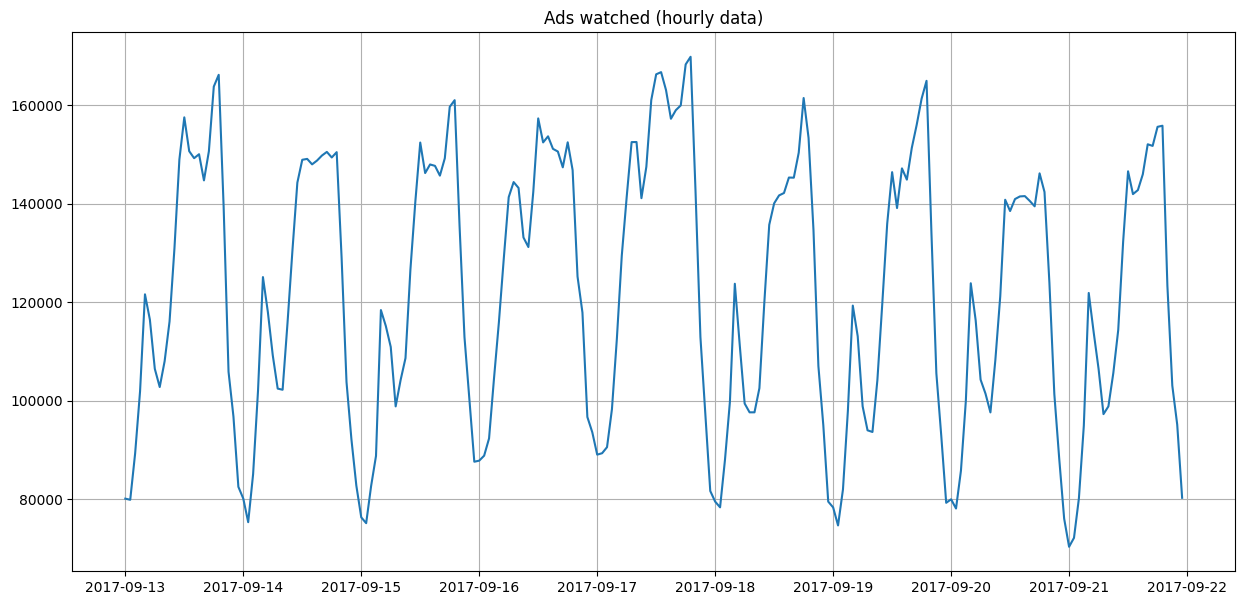

In [28]:
plt.figure(figsize=(15,7))
plt.plot(ads)
plt.title("Ads watched (hourly data)")
plt.grid(True)
plt.show()

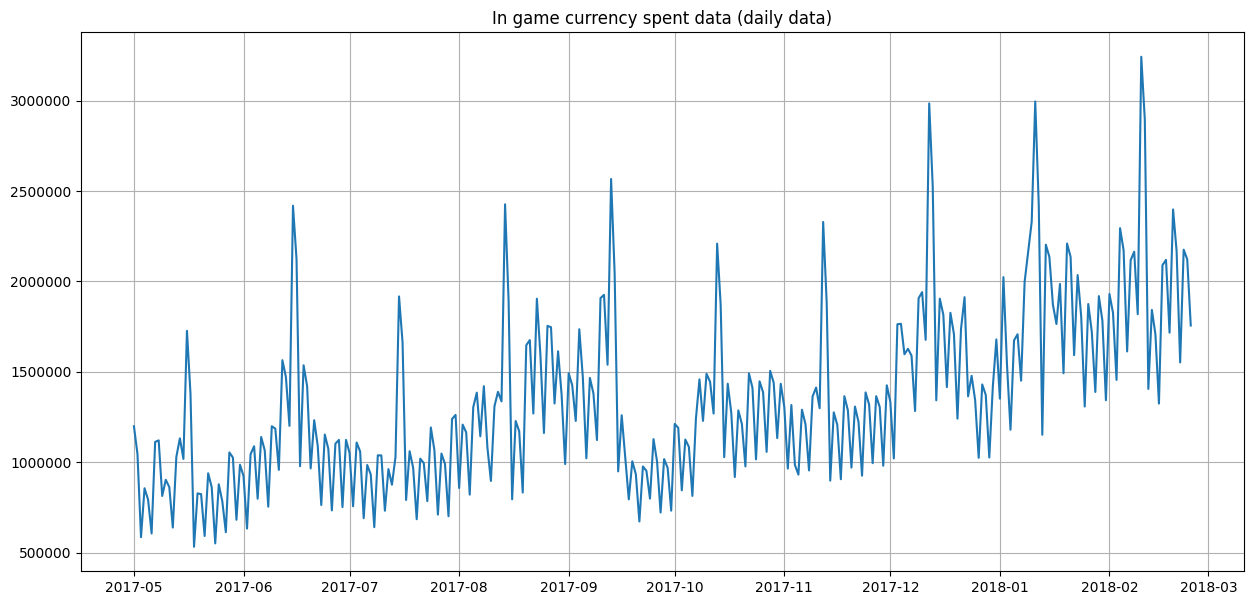

In [29]:
plt.figure(figsize=(15,7))
plt.plot(currency)
plt.title("In game currency spent data (daily data)")
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y') # To remove 'e' scientific notation of large numbers on y axis
plt.show()


In [30]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, median_absolute_error, mean_squared_log_error

# Smoothen Data

In [31]:
def moving_average(series, n):
    """ 
    Calculate average of last 'n' observations
    """

    return(np.average(series[-n:]))

l = [1,3,4,6,7,8,9,2,3]

print(moving_average(l,4))

5.5


In [32]:
moving_average(ads, n=24)

np.float64(116805.0)

In [90]:
def plotMovingAverage(series:pd.DataFrame, window, scale=1.96, plot_intervals=False, plot_anamolies=False):
    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    rolling_mean = series.rolling(window=window).mean()
    # print(rolling_mean)

    plt.figure(figsize=(15,7))
    plt.title(f"Moving average for window size {window}")
    plt.plot(rolling_mean, "g", label="rolling mean trend")
    plt.plot(series, "y", label="Raw Data")

    # # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:]) # standard deviation of errors (take the std(actual-rolling_mean)), how much value varies from rolling mean

        lower_bound = rolling_mean - (mae + scale*deviation)
        upper_bound = rolling_mean + (mae + scale*deviation)

        plt.plot(upper_bound, 'r--', label="Lower and Upper Bound")
        plt.plot(lower_bound, 'r--')

        if plot_anamolies:
            anamolies = pd.DataFrame(index=series.index, columns=series.columns)
            anamolies[series<lower_bound] = series[series<lower_bound]
            anamolies[series>upper_bound] = series[series>upper_bound]
            plt.plot(anamolies, "ro", markersize=20)
            # plt.scatter(anamolies.index, anamolies.values, color="red", s=80, zorder=5, label="Anomalies")
    
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

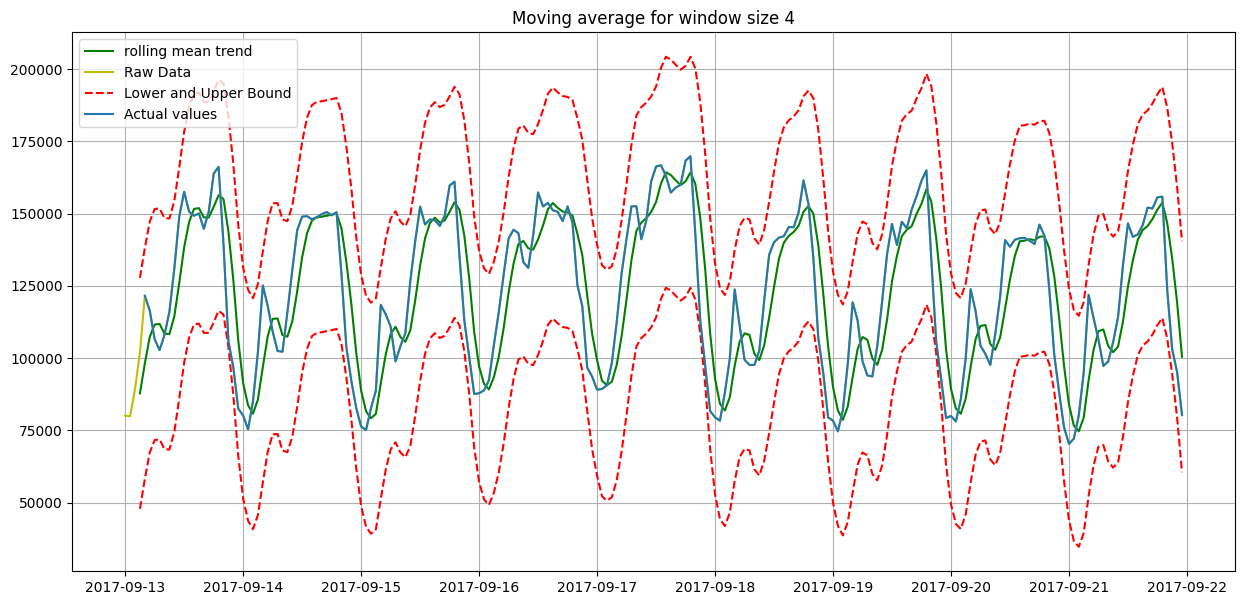

In [91]:
plotMovingAverage(ads, window=4, plot_intervals=True)

In [92]:
type(ads.Ads)

pandas.core.series.Series

In [93]:
a = pd.DataFrame([10,20,30], columns=["A"])
b = pd.Series([11,21,29])

a["A"]<b

an = pd.DataFrame(index=a.index, columns=a.columns)

an[a["A"]<b] = a[a["A"]<b]
# a

In [94]:
an

,A
0,10
1,20
2,NaN


Now, let's create a simple anomaly detection system with the help of moving average. Unfortunately, in this particular dataset, everything is more or less normal, so we will intentionally make one of the values abnormal in our dataframe ads_anomaly.

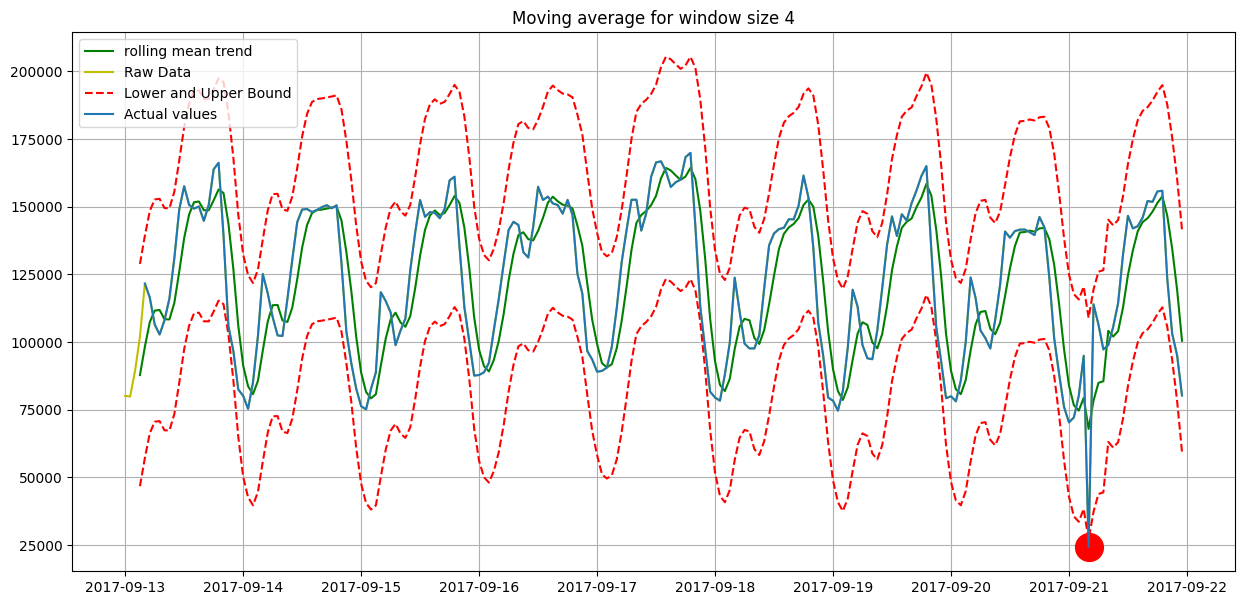

In [95]:
ads_anamoly = ads.copy()
ads_anamoly.iloc[-20] = ads_anamoly.iloc[-20]*0.2 # Lets say we drop the ads by 80%
plotMovingAverage(ads_anamoly, 4, plot_intervals=True, plot_anamolies=True)

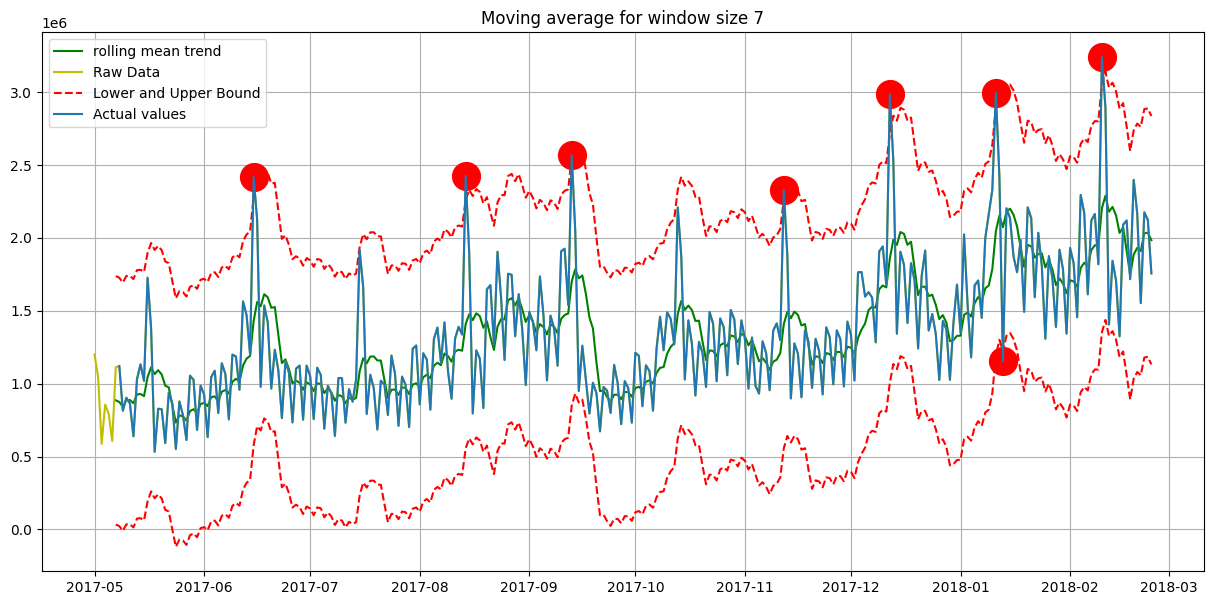

In [97]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anamolies=True)

# False Anamoly detection

>In the above graph, the repeated monthly spikes show a trend / seasonlity that is occurring in the data, so this is not an anamloy, but because our model is simplistic and gives equal weightage to each data point, it flags then as anamoly, which is false.

>So we need an approach that analyses and flags the anamolies by taking seasonlity into account or the repeated trend into account and doesn't create false positives

In [101]:
def weighted_average(series, weights):
    """
    Calculating Weigted average on the series.
    Assuming weights are sorted in descending order.
    Larger weights are assigned to the most recent observations.
    """
    result = 0.0

    for n in range(len(weights)):
        result += series.iloc[-n-1]*weights[n]
    return float(result)



In [100]:
np.mean(ads), len(ads), ads.iloc[-len(ads)]

(np.float64(121974.05092592593),
 216,
 Ads    80115
 Name: 2017-09-13 00:00:00, dtype: int64)

In [107]:
weighted_average(ads, [0.6, 0.3, 0.1])

87025.5

In [112]:

ads.loc[ads.index.max()]

Ads    80285
Name: 2017-09-21 23:00:00, dtype: int64

In [117]:
def ewm_smoothening(series, alpha):
    s = series[0]
    results = []
    for y in series[1:]:
        s = (alpha*y) + (1-alpha)*s
        results.append(round(s,2))
    
    return results

In [118]:
ewm_smoothening([10,12,13,14,16,16,19,17], 0.3)

[10.6, 11.32, 12.12, 13.29, 14.1, 15.57, 16.0]

In [123]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [124]:
def plotExponentialSmoothening(series: list | pd.Series , alphas):
    """
    Plot exponential smoothening with different alphas,
    Series : Dataset with timestamps
    Alphas : List of floats, smoothening parameters
    """

    with plt.style.context('seaborn-v0_8-white'):
        plt.figure(figsize=(15,7))
        for alpha in alphas:
            plt.plot(ewm_smoothening(series, alpha), label=f"Alpha {alpha}")
        
        if isinstance(series, list):
            actual_values = series
        elif isinstance(series, pd.Series):
            actual_values = series.values
        else:
            print("Please provide data either as series or list")

        plt.plot(actual_values, 'c', label="Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("EW Smoothening")
        plt.grid(True)

In [125]:
test_series=[10,12,13,14,16,16,19,17]

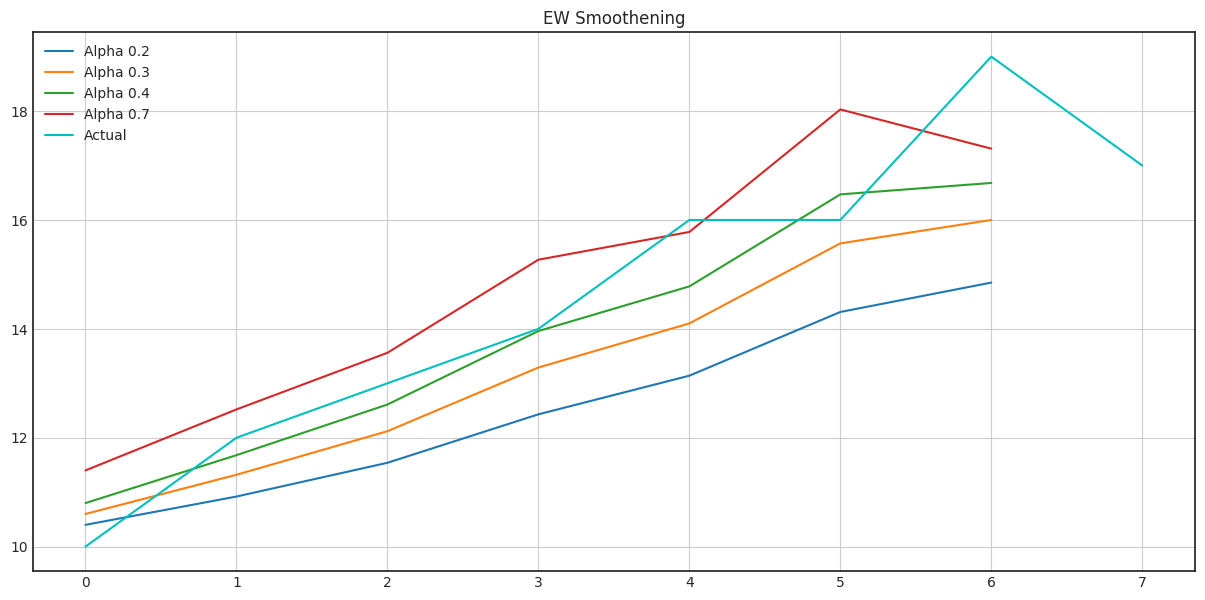

In [127]:
plotExponentialSmoothening(series=test_series, alphas=[0.2, 0.3, 0.4, 0.7])

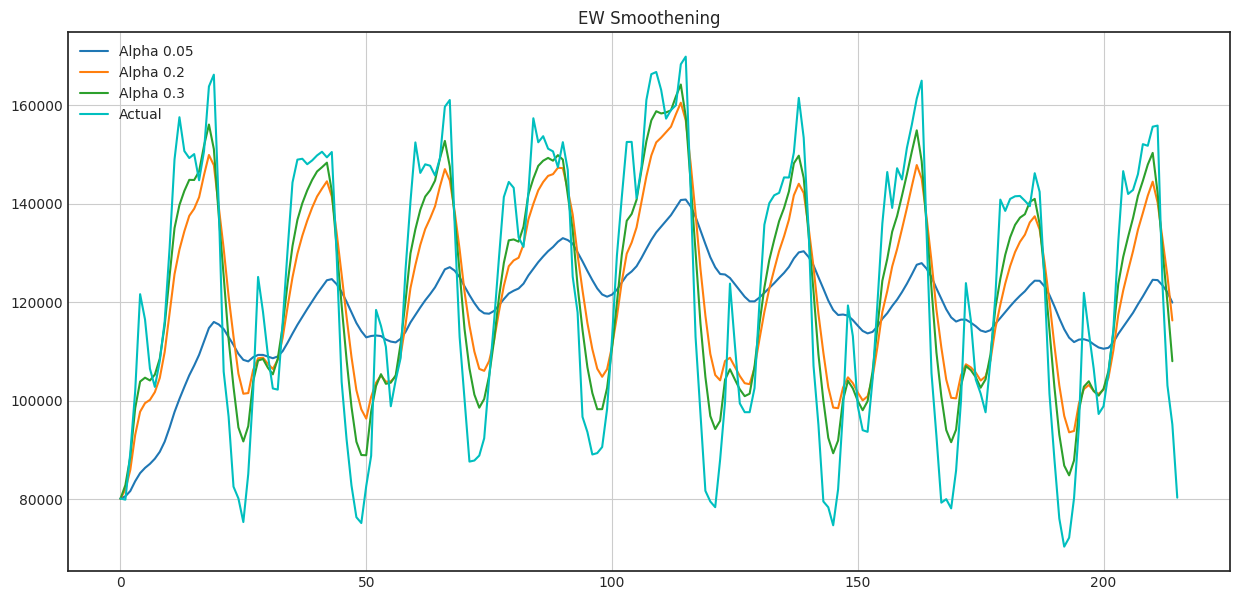

In [130]:
plotExponentialSmoothening(ads.Ads, alphas=[0.05, 0.2, 0.3])

# Single Smoothening cannot predict trend and forecast future values, why?

>The above single smoothening won't be able to capture trend, even though the graph goes upwards, because data values are increasing, but when asked to forecast a future point, it won't be able to predict that, because it gets stabalised at the last smoothened out point

>Lets see below example to understand this better

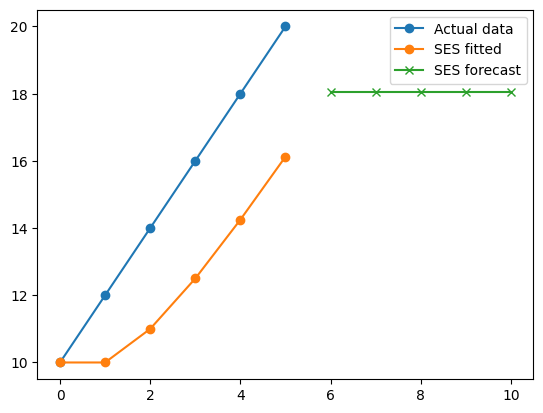

In [132]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

y = np.array([10, 12, 14, 16, 18, 20])

model = SimpleExpSmoothing(y).fit(smoothing_level=0.5, optimized=False)

forecast = model.forecast(5) # Forecast for next 5 values

plt.plot(y, label="Actual data", marker="o")
plt.plot(model.fittedvalues, label="SES fitted", marker="o")
plt.plot(range(len(y), len(y)+5), forecast, label="SES forecast", marker="x")
plt.legend()
plt.show()


>The fitted line follows the data upward but with a lag.

>The forecast line after the last point is flat (horizontal).

👉 This shows the failure of SES: it smooths well, but can’t capture trend in forecasting.

## But Why?

🔑 Core Idea of Single Exponential Smoothing (SES)

>SES assumes:

>Data is “wobbling” around a stable mean (like heart rate around 70, stock price around ₹100).

>Future ≈ weighted average of the past.

>That’s why the forecast is always a flat horizontal line: SES believes the process has no memory of slope, only of level.

In [136]:
def doubleExponentialSmoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n==1:
            level, trend = series[0], series[1]-series[0]
        if n>=len(series): ## Forecasting
            value = result[-1]
        else:
            value=series[n]
        
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result


def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """

    with plt.style.context('seaborn-v0_8-white'):
        plt.figure(figsize=(15,7))
        plt.plot(series.values, label='Actual')
        for alpha in alphas:
            for beta in betas:
                plt.plot(doubleExponentialSmoothing(series=series, alpha=alpha, beta=beta), label=f"Alpha {alpha} ; Beta {beta}")
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

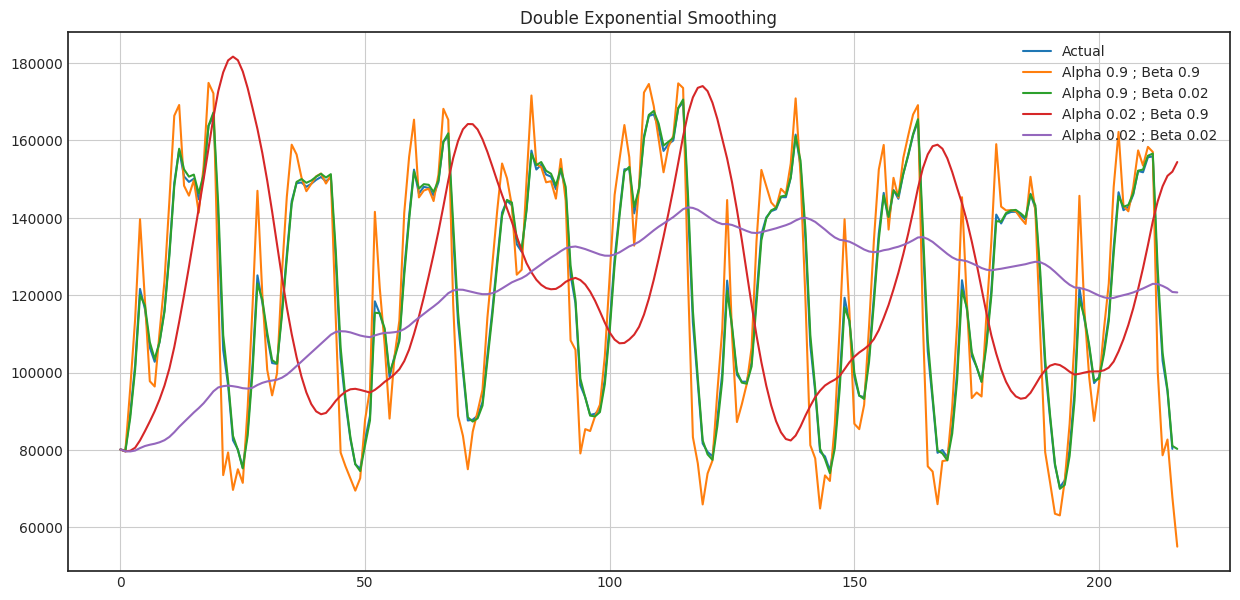

In [137]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

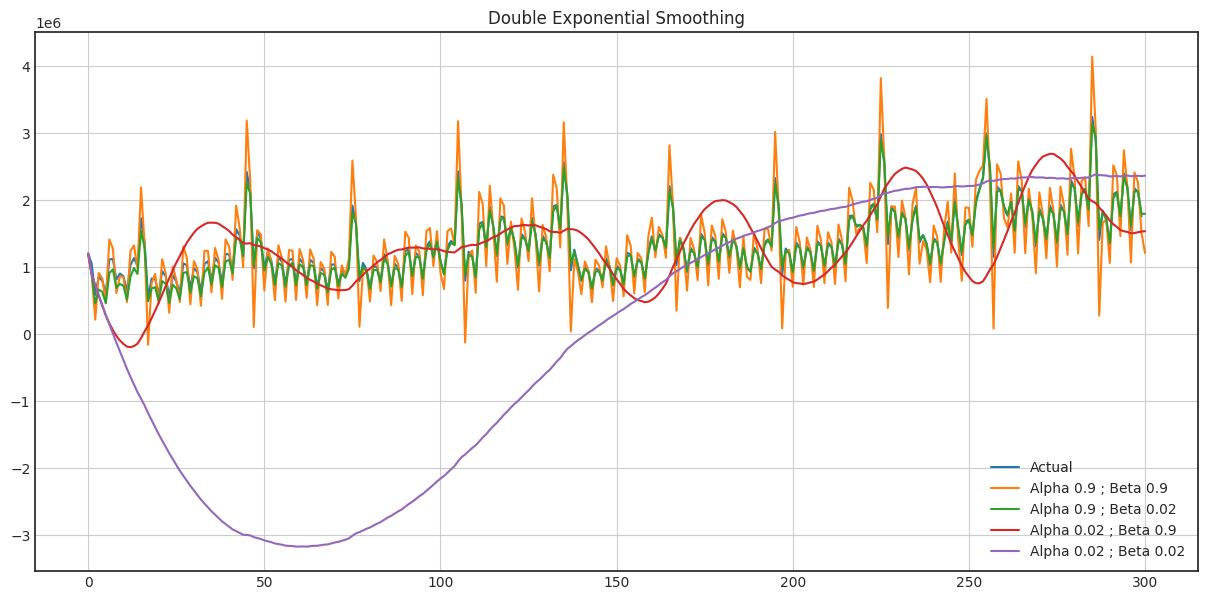

In [138]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

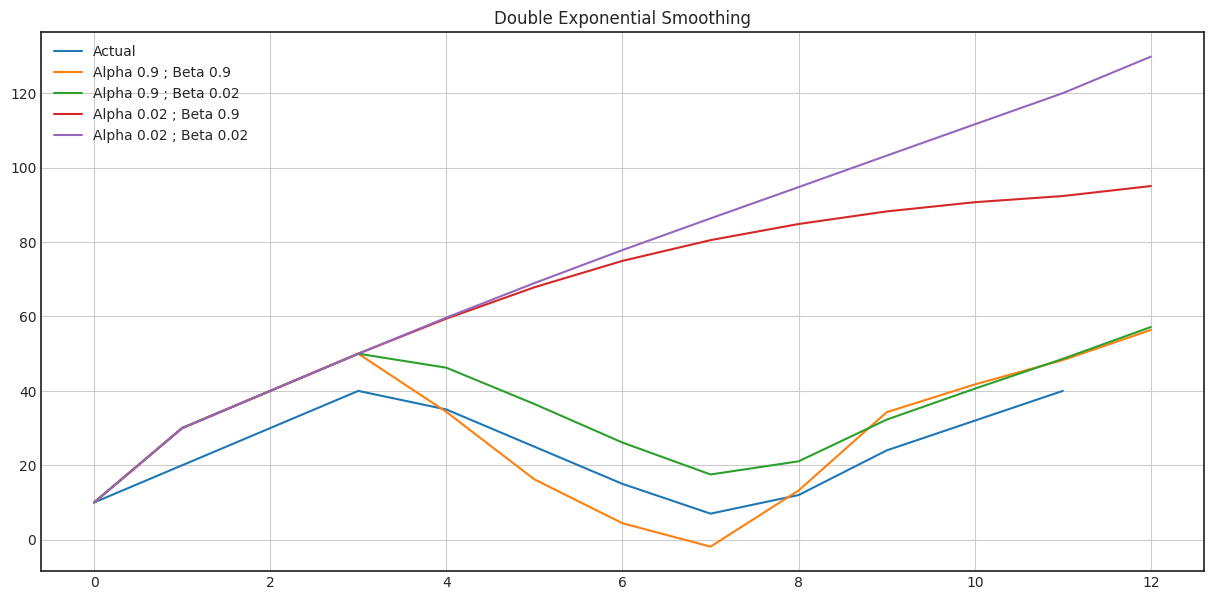

In [139]:
cyclical_series = pd.Series([10,20,30,40,35,25,15,7,12,24,32,40])
plotDoubleExponentialSmoothing(series=cyclical_series, alphas=[0.9, 0.02], betas=[0.9, 0.02])

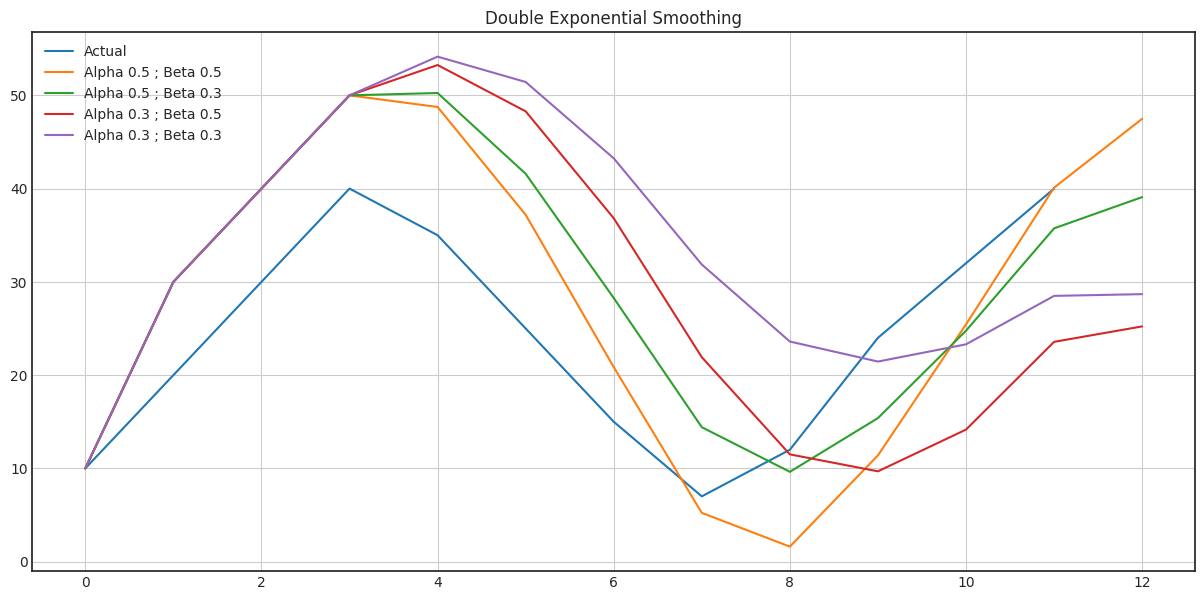

In [140]:
plotDoubleExponentialSmoothing(series=cyclical_series, alphas=[0.5, 0.3], betas=[0.5, 0.3])